<a href="https://colab.research.google.com/github/ErickAlcaino/MAT267-Series_De_Tiempo/blob/main/T1/T1Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pylab import rcParams
import statsmodels.api as sm
from astropy.timeseries import LombScargle
from scipy import stats


In [92]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps


In [93]:
# Cargar los datos
ozono = pd.read_csv('drive/MyDrive/Data/ozono.csv')

display(datainfo(ozono))

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
From Date,object,45538,45538,0,0.000000
CO (mg/m3),float64,44866,458,672,1.475691


In [94]:
display(ozono[ozono['CO (mg/m3)'].isnull()])

,From Date,CO (mg/m3)
266,1/30/2018 16:00,NaN
267,1/30/2018 17:00,NaN
268,1/30/2018 18:00,NaN
269,1/30/2018 19:00,NaN
270,1/30/2018 20:00,NaN
...,...,...
45255,3/20/2023 5:00,NaN
45256,3/20/2023 6:00,NaN
45257,3/20/2023 7:00,NaN
45258,3/20/2023 8:00,NaN


In [95]:
ozono['From Date'] = pd.to_datetime(ozono['From Date'])
ozono.set_index('From Date', inplace=True)

# 3. Crear la serie de tiempo con la columna 'CO (mg/m3)'
ozono_series = ozono['CO (mg/m3)']

# Mostrar los primeros registros de la serie de tiempo
display(ozono_series.head())

,CO (mg/m3)
From Date,
2018-01-19 14:00:00,0.50
2018-01-19 15:00:00,0.46
2018-01-19 16:00:00,0.84
2018-01-19 17:00:00,0.95
2018-01-19 18:00:00,1.24


In [96]:
curtosis = ozono_series.kurt()
sesgo = ozono_series.skew()

print(f'Curtosis: {curtosis}')
print(f'Sesgo (Skewness): {sesgo}')

display(ozono_series.describe())

Curtosis: 9.988191159983625
Sesgo (Skewness): 2.5810030118087823


,CO (mg/m3)
count,44866.000000
mean,0.714611
std,0.560215
min,0.000000
25%,0.400000
50%,0.560000
75%,0.830000
max,6.790000


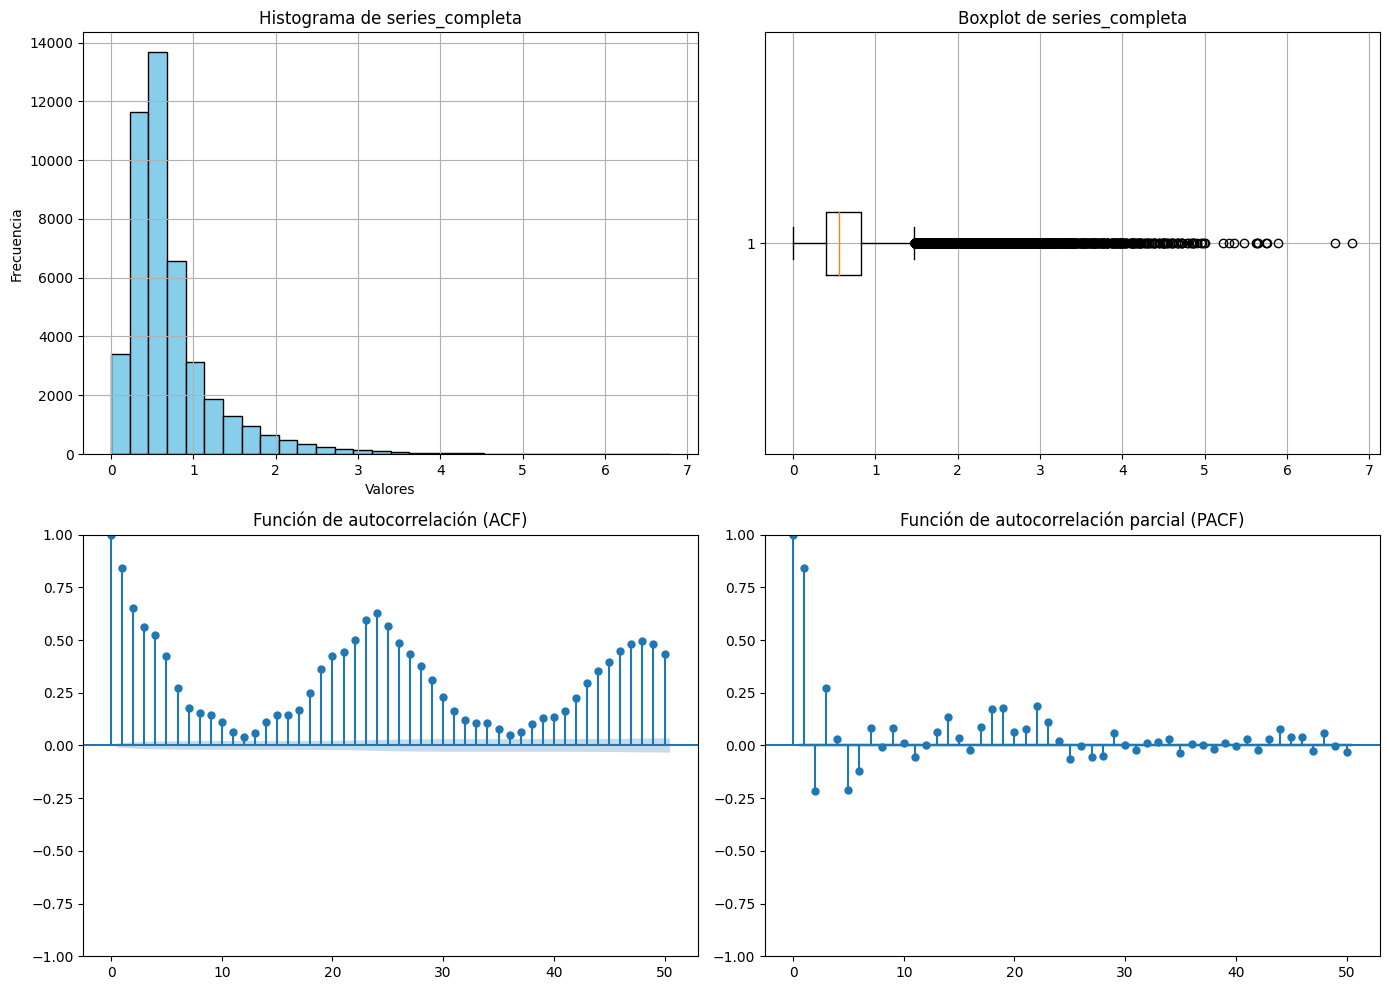

In [112]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Primer gráfico: Histograma
axs[0, 0].hist(ozono_series, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Histograma de series_completa')
axs[0, 0].set_xlabel('Valores')
axs[0, 0].set_ylabel('Frecuencia')
axs[0, 0].grid(True)

# Segundo gráfico: Boxplot
axs[0, 1].boxplot(ozono_series.dropna(), vert=False)
axs[0, 1].set_title('Boxplot de series_completa')
axs[0, 1].grid(True)

# Tercer gráfico: ACF
plot_acf(ozono_series.dropna(), lags=50, ax=axs[1, 0])
axs[1, 0].set_title('Función de autocorrelación (ACF)')

# Cuarto gráfico: PACF
plot_pacf(ozono_series.dropna(), lags=50, ax=axs[1, 1])
axs[1, 1].set_title('Función de autocorrelación parcial (PACF)')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

In [98]:
#rellenar con los datos de 1 semana antes para mantener comportamiento.

ozono_completa = ozono_series.copy()
ozono_completa = ozono.fillna(ozono.shift(7*24))
ozono_completa = ozono_completa.fillna(ozono_completa.shift(7*24)) ## dos veces ya que quedaban 16 datos sin rellenar al hacerlo 1 vezx

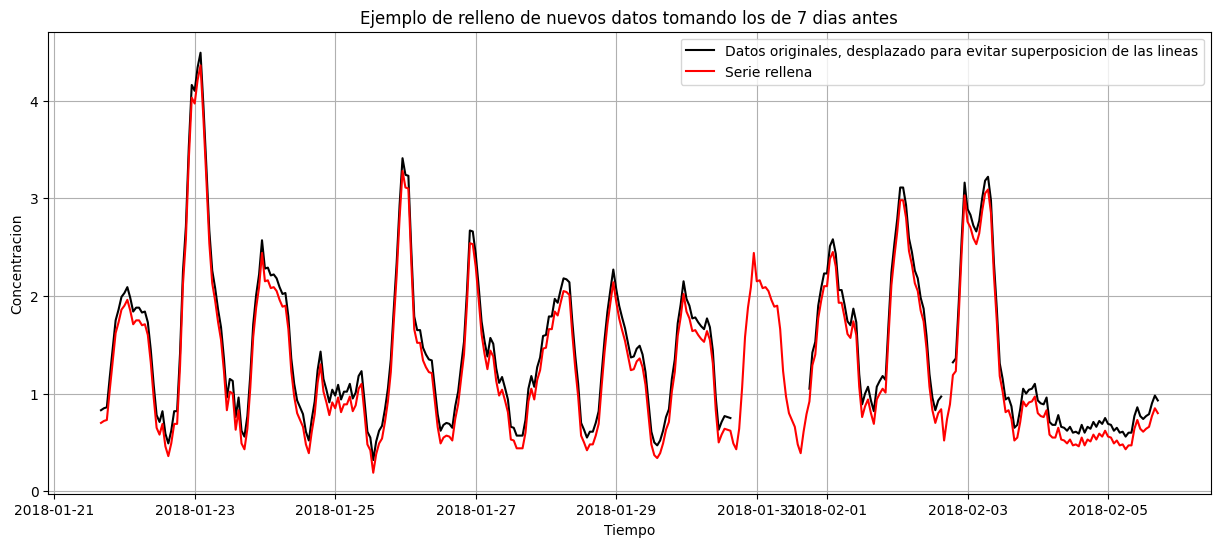

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
CO (mg/m3),float64,45538,458,0,0.0


In [99]:
# Graficar los datos reales y las predicciones
plt.figure(figsize=(15, 6))
plt.plot(ozono_series['1/21/2018 16:00':'2/5/2018 17:00']+0.13, label='Datos originales, desplazado para evitar superposicion de las lineas', color='black')
plt.plot(ozono_completa['1/21/2018 16:00':'2/5/2018 17:00'], label='Serie rellena', color='red')
plt.title('Ejemplo de relleno de nuevos datos tomando los de 7 dias antes')
plt.xlabel('Tiempo')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

display(datainfo(ozono_completa))

In [100]:
#media_movil = ozono_completa.rolling(window=24, center=True).mean()
# Segunda aplicación de la media móvil
#for i in range(1,4):
  #media_movil = media_movil.rolling(window=24, center=True).mean()

#plt.figure(figsize=(16, 8))
#plt.plot(ozono_completa[-100:], label='Serie completa', color='blue')
#plt.plot(media_movil[-100:], label='1ta media movil', color='red')
#plt.title('Serie de Tiempo Ozono')
#plt.xlabel('Tiempo')
#plt.ylabel('Velocidad del Viento')
#plt.legend()
#plt.grid(True)
#plt.show()

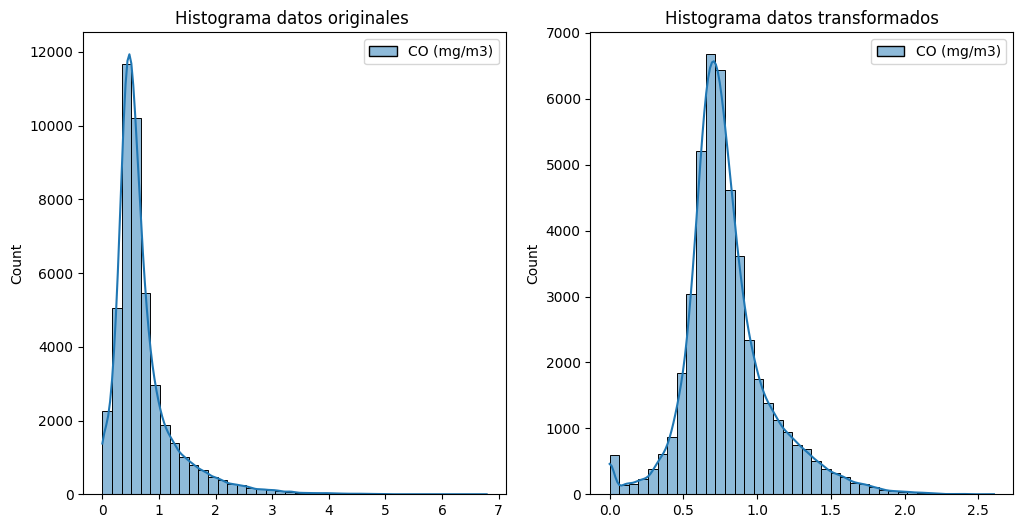

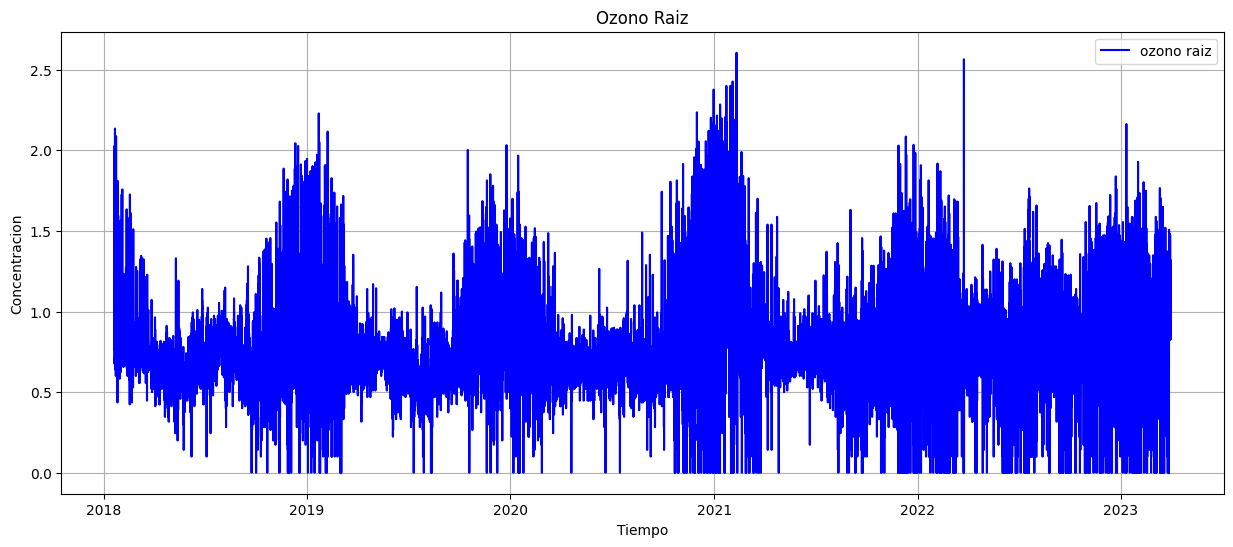

In [115]:
ozono_raiz= np.power((ozono_completa),1/2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ozono_completa, bins=40, kde=True)
plt.title('Histograma datos originales ')
plt.subplot(1, 2, 2)
sns.histplot(ozono_raiz, bins=40, kde=True)
plt.title('Histograma datos transformados')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(ozono_raiz, label='ozono raiz', color='blue')
plt.title('Ozono Raiz')
plt.xlabel('Tiempo')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
curtosis = ozono_raiz.kurt()
sesgo = ozono_raiz.skew()

print(f'Curtosis: {curtosis}')
print(f'Sesgo (Skewness): {sesgo}')

Curtosis: CO (mg/m3)    2.500072
dtype: float64
Sesgo (Skewness): CO (mg/m3)    0.844613
dtype: float64


In [103]:
modelo_hw = ExponentialSmoothing(ozono_raiz,
                                 trend='add',      # tendencia aditiva
                                 seasonal='add',   # estacionalidad aditiva
                                 seasonal_periods=24).fit()  # ajusta el modelo

residuos = modelo_hw.resid

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


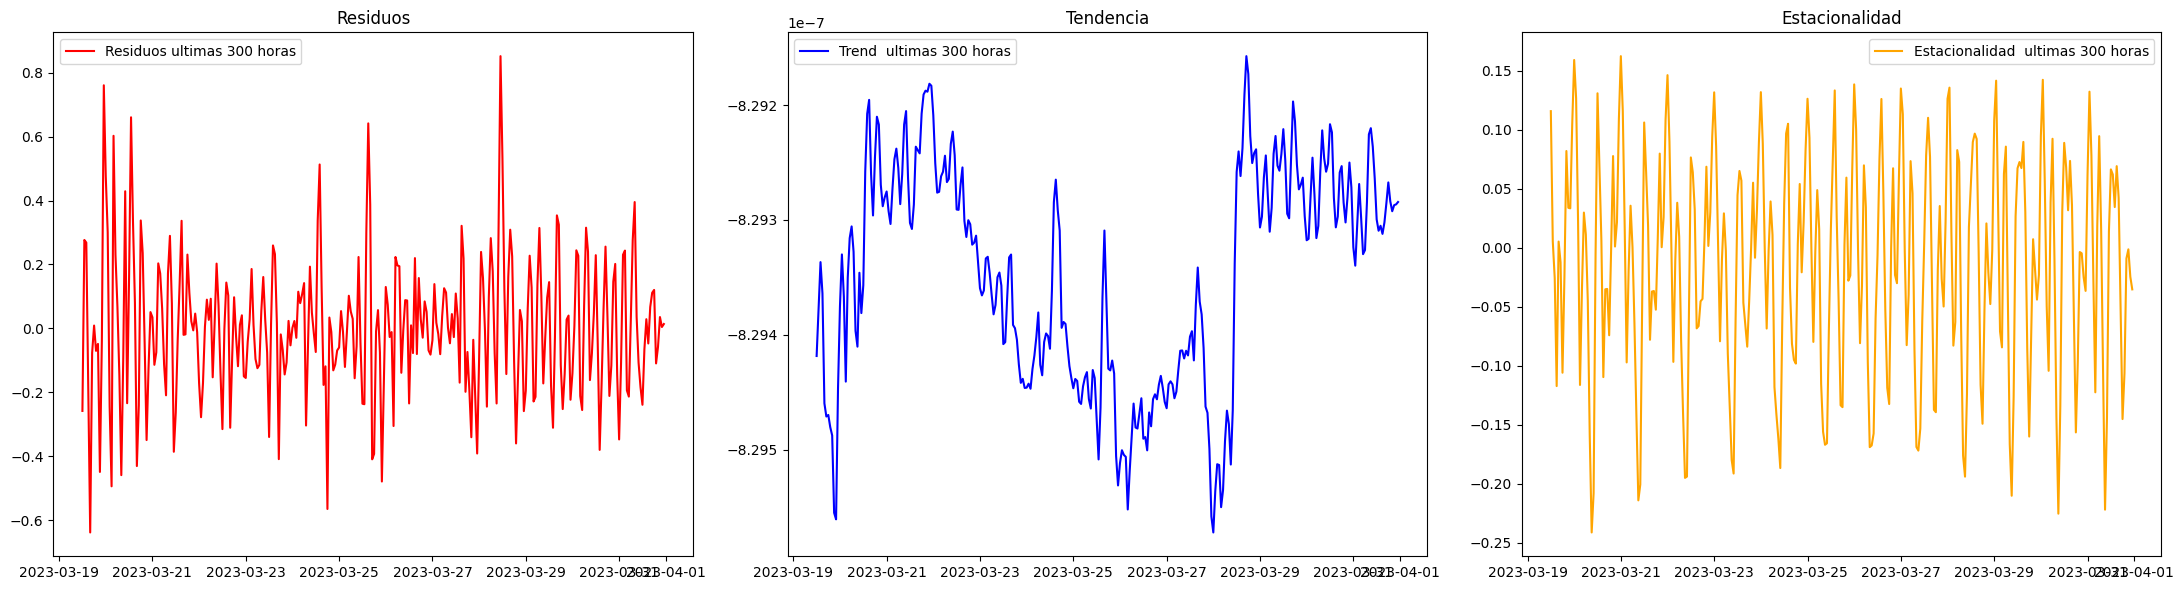

In [104]:
plt.figure(figsize=(22, 6))

# Primer gráfico: Residuos
plt.subplot(1, 3, 1)  # 1 fila, 3 columnas, primer gráfico
plt.plot(residuos[-300:], label='Residuos ultimas 300 horas', color='red')
plt.legend()
plt.title('Residuos')

# Segundo gráfico: Tendencia
plt.subplot(1, 3, 2)  # 1 fila, 3 columnas, segundo gráfico
plt.plot(modelo_hw.trend[-300:], label='Trend  ultimas 300 horas', color='blue')
plt.legend()
plt.title('Tendencia')

# Tercer gráfico: Estacionalidad
plt.subplot(1, 3, 3)  # 1 fila, 3 columnas, tercer gráfico
plt.plot(modelo_hw.season[-300:], label='Estacionalidad  ultimas 300 horas', color='orange')
plt.legend()
plt.title('Estacionalidad')

# Mostrar la figura con los 3 gráficos en una fila
plt.tight_layout()  # Ajusta el espaciado entre los gráficos
plt.show()

In [105]:
adf = adfuller(residuos)
print(f'ADF Statistic: {adf[0]}')
print(f'p-value : {adf[1]}')
print(f'Critical Values : {adf[4]}')

ADF Statistic: -37.75301777354708
p-value : 0.0
Critical Values : {'1%': -3.4304937890353244, '5%': -2.8616035516614233, '10%': -2.5668038264717588}


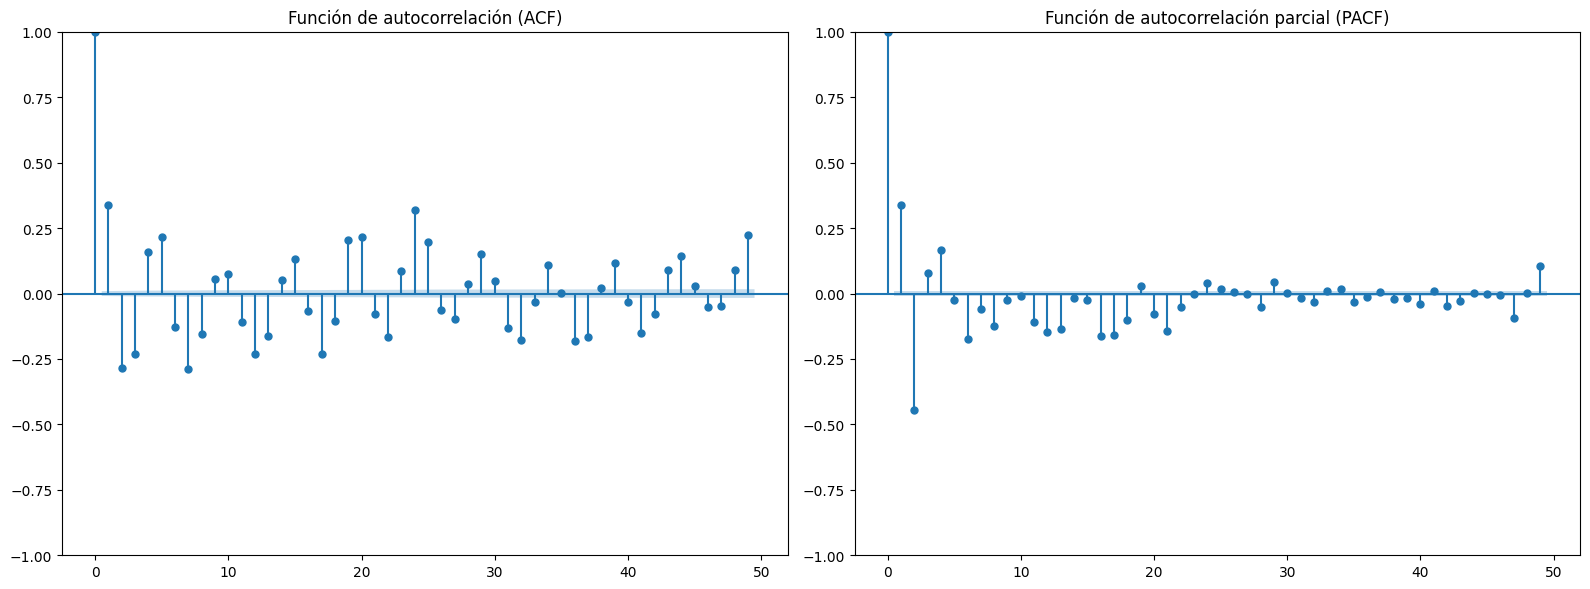

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graficar la ACF en el primer subplot (izquierda)
plot_acf(residuos, lags=49, ax=axes[0])
axes[0].set_title('Función de autocorrelación (ACF)')

# Graficar la PACF en el segundo subplot (derecha)
plot_pacf(residuos, lags=49, ax=axes[1])
axes[1].set_title('Función de autocorrelación parcial (PACF)')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


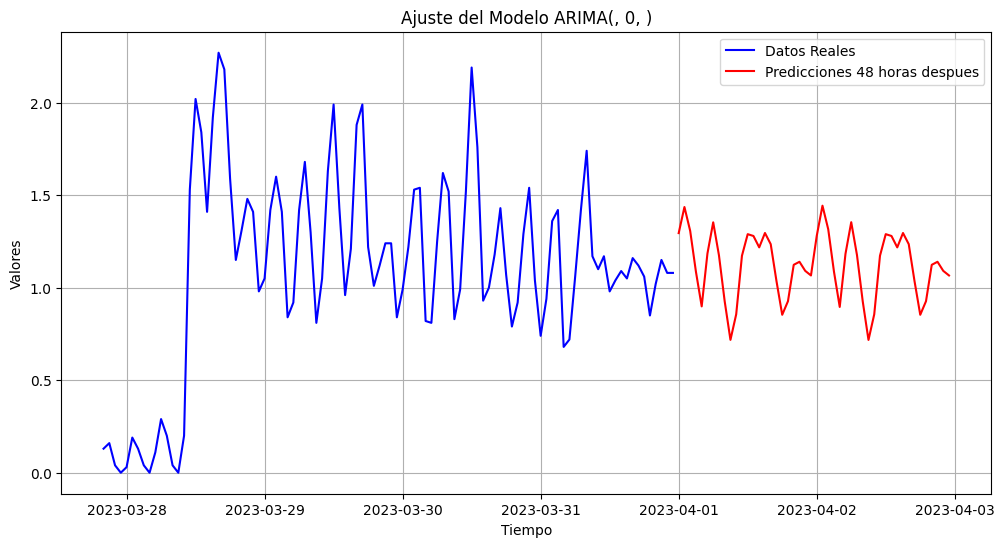

In [118]:
#SOLO PARA Probar

model = ARIMA(residuos, order=(2, 0,1))
model_fit = model.fit()

ajuste = model_fit.fittedvalues

pred_hw_arima = modelo_hw.forecast(steps=48) + model_fit.forecast(steps=48)
predicciones = np.power((pred_hw_arima),2)

reales=ozono_completa[-100:]


# Graficar los datos reales y las predicciones


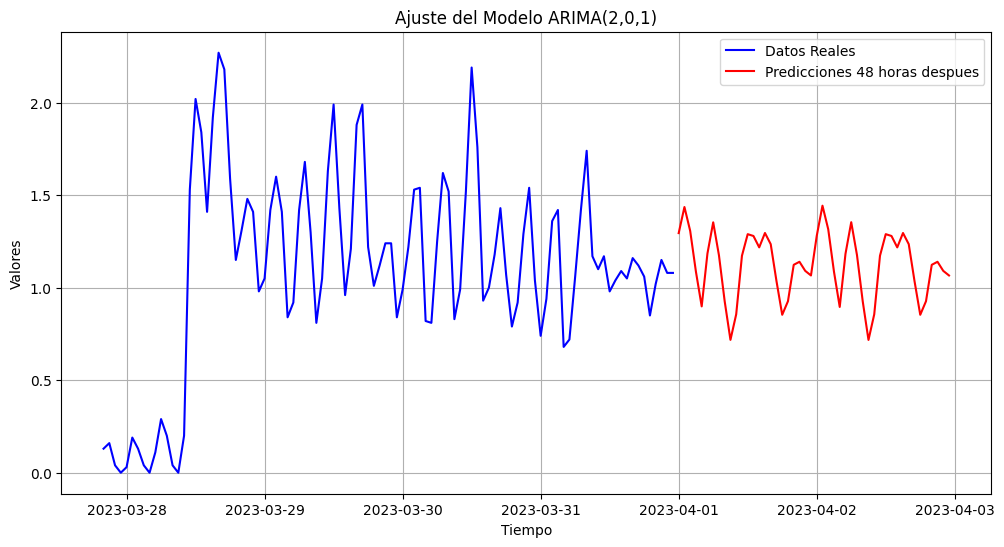

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(reales, label='Datos Reales ', color='blue')
plt.plot(predicciones, label='Predicciones 48 horas despues', color='red')
plt.title('Ajuste del Modelo ARIMA(2,0,1)')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()